In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import scipy.stats as stats

In [20]:

# standard deviation of spherical Gaussian distribution
mu = 0.0 #zero-mean
sigma_u = 1.0
sigma_v = 1.0
sigma = [0, 0.2, 0.4, 0.6, 0.8, 1] 

# Generate U, V from the Gaussian distribution
D = 2 #dimension
N = 10 #nbr of users = 10
M = 10 #nbr of movies : M=5*alpha M = 10, 30, 100, 300, 1000
alpha_vals = [1, 3, 10, 30, 100] #[1,5,10,50,100]
k_best = 10 # 
nb_iter = 20 #100


In [21]:
#generate matrices U, V and R from Gauss. distributions

def generate_U_V_R(s, alpha):
    U = np.random.normal(mu, sigma_u, size=(D,N))
    V = np.random.normal(mu, sigma_v, size=(D,M*alpha))
    noise = np.random.normal(mu, s, size=(N,M*alpha)) 
    R = np.matmul(U.T,V) +noise
    return U, V, R

In [22]:
#map values to discrete ratings 

def condition(x):
    if x<-2:
        return 1
    elif x>=-2 and x<=-0.5:
        return 2
    elif x>-0.5 and x<=0.5:
        return 3
    elif x>0.5 and x<=2:
        return 4
    else:
        return 5

In [23]:
#compute similarity list of matrix U for a given user i

def similarity_list(U, user_i): # add user_i to the sim_fn
    df_U = pd.DataFrame(U)
    sim_array= cosine_similarity(df_U)[user_i] # for user i, i=0
    df_U['similarity_u1']= sim_array.tolist()
    df_U= df_U.sort_values(by= 'similarity_u1', ascending= False)
    user1_sim_list= df_U.index
    return user1_sim_list

In [24]:
#compute kendalltau ranking similarity of 2 ranking lists for k_best rankings

def ranking_similarity(u1_list_U, u1_list_R, k_best):
    tau, p_value = stats.kendalltau(u1_list_U[:k_best], u1_list_R[:k_best])
    return tau


In [25]:
#compute average of kendalltau similarity for all users for given matrices U and R

def sim_avg_users(U, R):
    sum_similarities= 0
    for user_i in range(N):
        similarity_list_U = similarity_list(U.T, user_i)
        similarity_list_R = similarity_list(R, user_i)
        kd_tau = ranking_similarity(similarity_list_U, similarity_list_R, k_best)
        sum_similarities+= kd_tau
    return sum_similarities/N    
        

In [26]:
#compute averaged similarities for different values of M and sigma

data= []
for s in sigma:
    for alpha in alpha_vals:
        for k in range(nb_iter):
            U, V, R= generate_U_V_R(s, alpha)
            similarities= sim_avg_users(U, R)
            row= [M*alpha, s, similarities]
            data.append(row)

In [27]:
df = pd.DataFrame(data, columns=['M','sigma','sim_U_R'])
df_res= df.groupby(by=['M','sigma']).mean()
df_res.head(8)

sim_U_R
M  sigma          
10 0.0    0.670000
   0.2    0.467333
   0.4    0.429778
   0.6    0.310444
   0.8    0.217333
   1.0    0.221111
30 0.0    0.780000
   0.2    0.625333

In [28]:
df_res['sim_U_R'].unstack()

sigma,0.0,0.2,0.4,0.6,0.8,1.0
M,,,,,,
10,0.670000,0.467333,0.429778,0.310444,0.217333,0.221111
30,0.780000,0.625333,0.430889,0.367778,0.337778,0.291111
100,0.887333,0.689333,0.622889,0.571778,0.396444,0.368444
300,0.940222,0.740667,0.628667,0.535778,0.501778,0.415111
1000,0.958444,0.778222,0.646000,0.597778,0.483778,0.522000


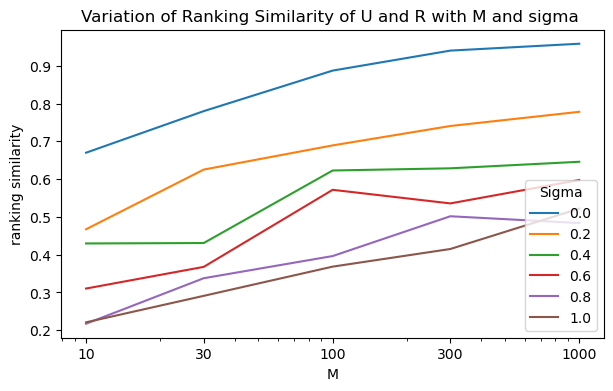

In [29]:
M_vals = [10, 30, 100, 300, 1000]

fig, ax = plt.subplots(figsize=(7,4))
df_res['sim_U_R'].unstack().plot(ax=ax)
plt.legend(title= 'Sigma', loc='lower right')
plt.title('Variation of Ranking Similarity of U and R with M and sigma ')
plt.xscale('log')
plt.xticks(M_vals, M_vals)
plt.xlabel('M')
plt.ylabel('ranking similarity')

plt.show()

# SVD

In [12]:
#compute averaged similarities for matrices U_svd and U for different values of M and sigma

data= []
for s in sigma:
    for alpha in alpha_vals:
        for k in range(nb_iter):
            U, V, R = generate_U_V_R(s, alpha)
            U_svd, D_svd, VT_svd = np.linalg.svd(R, full_matrices=False)
            similarities= sim_avg_users(U_svd.T, U.T)
            row= [M*alpha, s, similarities]
            data.append(row)
# print values of D : diagonal values 

In [13]:
df = pd.DataFrame(data, columns=['M','sigma','sim_U_R'])
df_res= df.groupby(by=['M','sigma']).mean()
df_res['sim_U_R'].unstack()

sigma,0.0,0.2,0.4,0.6,0.8,1.0
M,,,,,,
8,0.108444,0.098444,0.115556,0.093333,0.084000,0.086000
24,0.118667,0.117111,0.083333,0.079556,0.075556,0.078222
80,0.086889,0.068889,0.093333,0.104444,0.111778,0.091556
240,0.098889,0.082667,0.055556,0.084222,0.097556,0.125556
800,0.099111,0.132000,0.098889,0.098222,0.100000,0.111111


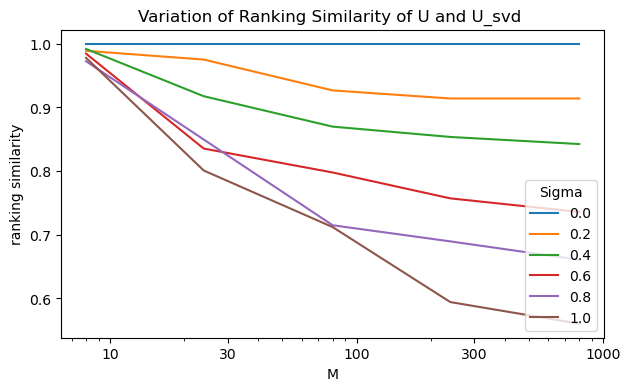

In [17]:
fig, ax = plt.subplots(figsize=(7,4))
df_res['sim_U_R'].unstack().plot(ax=ax)
plt.legend(title= 'Sigma', loc='lower right')
plt.title('Variation of Ranking Similarity of U and U_svd ')
plt.xscale('log')
plt.xticks(M_vals, M_vals)
plt.xlabel('M')
plt.ylabel('ranking similarity')

plt.show()

# Truncated SVD

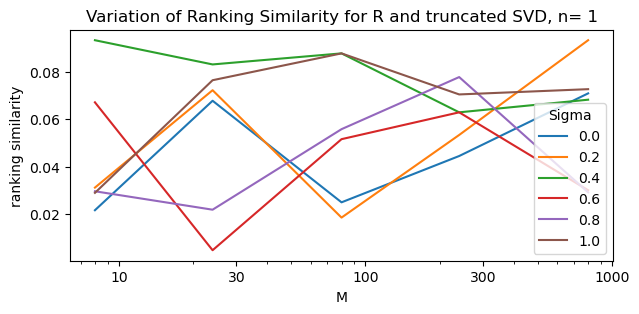

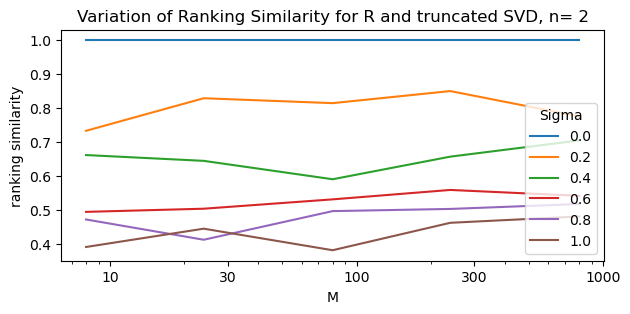

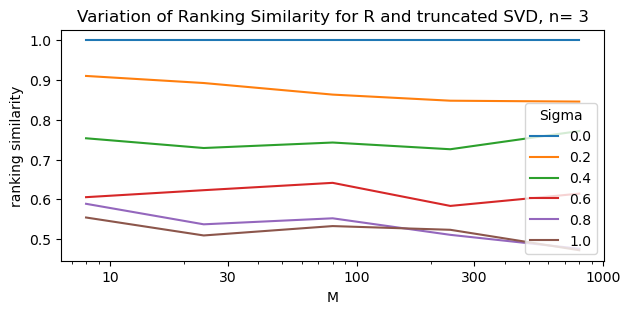

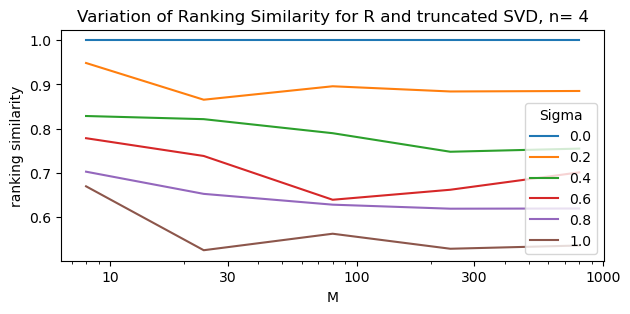

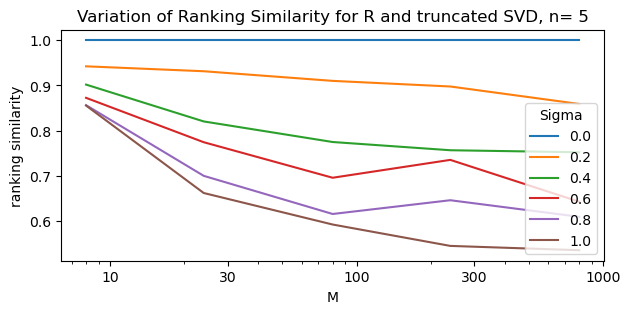

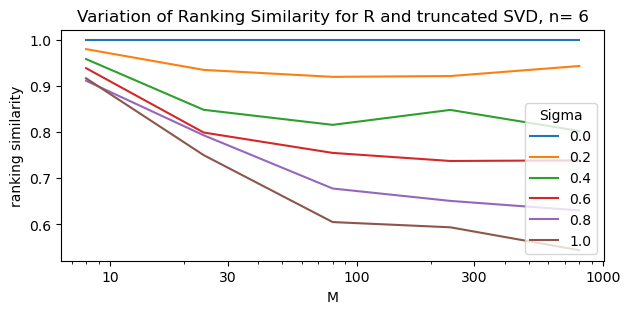

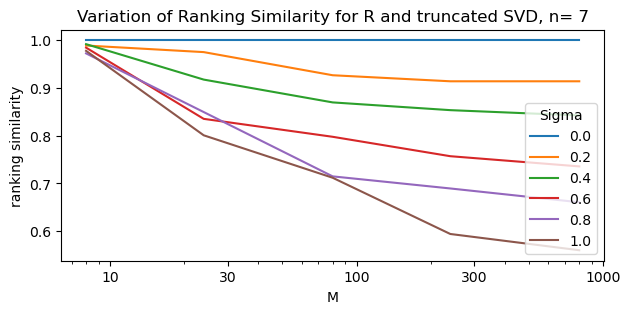

In [15]:
#compute averaged similarities for matrices R and transformed matrix trun_svd
#for different values of M and sigma and 

for nb_components in range(1,M,1):
    data= []
    for s in sigma:
        for alpha in alpha_vals:
            for k in range(nb_iter):
                U, V, R = generate_U_V_R(s, alpha)
                trun_svd = TruncatedSVD(n_components = nb_components).fit_transform(R)
                similarities= sim_avg_users(trun_svd.T, R)
                row= [M*alpha, s, similarities]
                data.append(row)
    
    
    df= pd.DataFrame(data, columns=['M','sigma','sim_U_R'])
    df_res= df.groupby(by=['M','sigma']).mean()
    df_res['sim_U_R'].unstack()
    
    fig, ax = plt.subplots(figsize=(7,3))
    df_res['sim_U_R'].unstack().plot(ax=ax)
    plt.legend(title= 'Sigma', loc='lower right')
    plt.title('Variation of Ranking Similarity for R and truncated SVD, n= {}'.format(nb_components) )
    plt.xscale('log')
    plt.xticks(M_vals, M_vals)
    plt.xlabel('M')
    plt.ylabel('ranking similarity')
    plt.show()